In [1]:
# funcoes genericas que podem ser re-usadas em outros problemas

import math
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib as mpl
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


# funcoes base para implementar o Euler. 
# Deve-se implementar a funcao rates, que depende de cada modelo.

def initStateVector(s):
    return np.array(s)

def updateStateVectorEuler(s,dt, rateFunc):
    return s + rateFunc(s,dt)

# State Vector Trajectories store state space evolution. Uses list to init empty.

def initSVTrajectory():
    return []

# append s a svt
def updateSVTrajectory(svt,s):
    svt.append(s)
    return svt

def extractSVTrajectory(svt,i): # returns the trajectory as numpy array
    foo = np.array(svt)
    return foo[:,i]
  
def plotEuler(vxe, vtime):
    fig, ax = pyplot.subplots()
    pyplot.plot(vtime, vxe, label='Euler',linestyle='',marker='o') 
    pyplot.title('Posição')
    ax.set_xlabel('Tempo (segundos)')
    ax.set_ylabel('Posição (metros)')
    pyplot.show(block=False)
    
def erroTrajetorias(v1,v2,tipoErro):
    if (tipoErro == 0): # erro com sinal
        return(np.array(v1) - np.array(v2))
    elif (tipoErro == 1): # erro quadratico
        return((np.array(v1) - np.array(v2))**2)
    elif (tipoErro == 2): # erro em modulo
        return(fabs((np.array(v1) - np.array(v2))))
    

def easyPlot(v,title):
    pyplot.figure()
    pyplot.plot(v)
    pyplot.title(title)
    pyplot.show()

def easyPlot2D(x,y,title, df, col, xlabel, ylabel, scatter = True):
    pyplot.figure()
    pyplot.plot(x, y, label = 'Simulação')
    pyplot.scatter(df.time, df[col], c = 'tab:orange', label = 'Experimento')
    pyplot.plot(df.time, df[col], c = 'tab:orange') 
    pyplot.title(title)
    pyplot.legend()
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()
    
def easyPlot3D(x,y,z,title,xl,yl,zl):
    mpl.rcParams['legend.fontsize'] = 10
    fig = pyplot.figure()
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, label=title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_zlabel(zl)
    ax.legend()
    pyplot.show()


In [2]:
dfP = pd.read_csv('DATA/pWVel.csv')
dfFF = pd.read_csv('DATA/ffWVel.csv')

Equações Queda Livre:

$$a_i = g - b \cdot v_i$$
$$\frac{d}{dt}(v) = a \Rightarrow v_{i+1} = a_{i} \cdot dt + v_{i}$$
$$\frac{d}{dt}(x) = v \Rightarrow x_{i+1} = v_{i} \cdot dt + x_{i}$$

In [13]:
def ratesFreeFall(s,dt):
    g = 9.8
    r0 = s[1]*dt #+thetai
    r1 = g*dt
    r2 = dt
    return np.array([r0,r1,r2])

def ratesFreeFallWithDrag(s, dt):
    g = 9.8
    dragCoefficient = 5
    a = 9.8 - dragCoefficient*s[1]
    r0 = s[1]*dt #+thetai
    r1 = a*dt
    r2 = dt
    
    return np.array([r0,r1,r2])

def ratesPendulum(s,dt):
    g = 9.8
    L = 0.2905
    r1 = (-g*s[0]*dt)/L #+omegai 
    r0 = (s[1] + r1)*dt #+thetai
    r2 = dt
    return np.array([r0,r1,r2])

def simulate(df, positionName, experimentName, rateFunction, positionUnity, filmNumber):
    
    dff = df.loc[df['experiment'] == filmNumber]

    firstrow = dff.iloc[0]

    t0 = dff.time.min()
    it0 = dff.time.idxmin()
    tf = dff.time.max()
    x0 = firstrow[positionName]
    v0 = firstrow['velocity']
    dt = 0.01
    #dt = dff.time[it0 + 1] - dff.time[it0]

    stateVectorEuler = initStateVector([x0,v0,t0])
    stateVectorEuler = initStateVector([x0,v0,t0])


    svtEuler = initSVTrajectory() 

    while (stateVectorEuler[2] < tf + dt/2):    
        svtEuler        = updateSVTrajectory(svtEuler,list(stateVectorEuler))
        stateVectorEuler = updateStateVectorEuler(stateVectorEuler,dt, rateFunction)

    vx = extractSVTrajectory(svtEuler,0)
    vv = extractSVTrajectory(svtEuler,1)
    vtime = extractSVTrajectory(svtEuler,2)

    easyPlot2D(vtime, vx, f'Simulação da posição para filmagem {filmNumber} ({experimentName})', dff, positionName, 'Tempo (s)', f'Posição ({positionUnity})')
    easyPlot2D(vtime, vv, f'Simulação velocidade para filmagem {filmNumber} ({experimentName})', dff, 'velocity', 'Tempo(s)', f'Velocidade ({positionUnity}/s)')

Vamos simular posição e velocidade para a filmagem 1 de cada experimento.

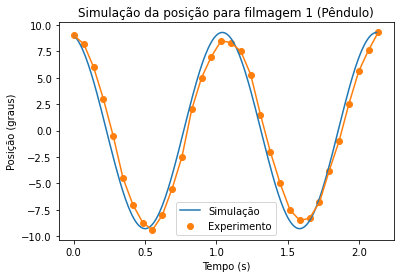

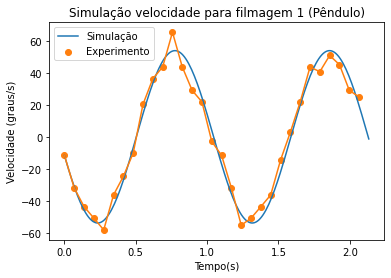

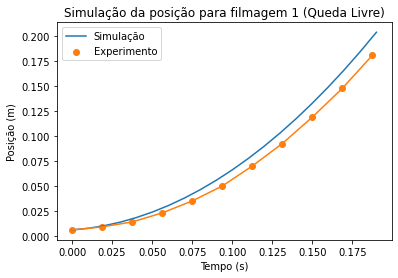

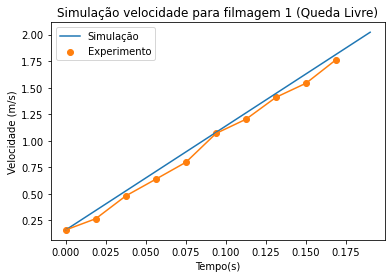

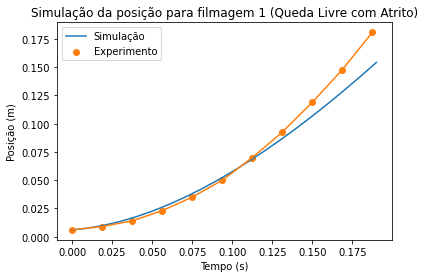

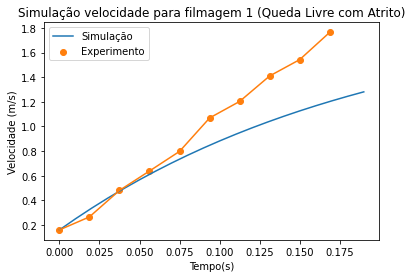

In [15]:
simulate(dfP, 'angle', 'Pêndulo', ratesPendulum, 'graus', 1)        
simulate(dfFF, 'position', 'Queda Livre', ratesFreeFall, 'm', 1)   
simulate(dfFF, 'position', 'Queda Livre com Atrito', ratesFreeFallWithDrag, 'm', 1)   

Vamos escrever testes para funções que não são de plot

In [50]:
import unittest
class TestNotebook(unittest.TestCase):

    def test_initSVTrajectory(self):
        self.assertEqual(initSVTrajectory(), [])
        
    def test_initStateVector(self):
        s1 = np.array([1,2,3])
        s2 = initStateVector([1,2,3])
        self.assertTrue((s1 == s2).all())
    
    def test_updateStateVectorEuler(self):
        
        def rateFunction(foo, boo):
            return np.array([1,2,3])
        
        s = np.array([1,2,3])
        s1 = updateStateVectorEuler(s,0,rateFunction)
        s2 = np.array([2,4,6])
        self.assertEqual(list(s1), list(s2))
        
    
    def test_updateSVTrajectory(self):
        
        s = [[1,2,3]]
        s1 = [[1,2,3], [4,5,6]]
        s2 = updateSVTrajectory(s, [4,5,6])
        self.assertEqual(s1, s2)
    
    def test_extractSVTrajectory(self):
        s = [[1,2,3], [4,5,6]]
        s1 = extractSVTrajectory(s, 1)
        self.assertEqual(list(s1), [2, 5])    

    def test_ratesFreeFall(self):
        
        s1 =  ratesFreeFall([1,2,3], 3)
        s2 = [6, 29.4, 3]

        for i in range(0, 3):
            self.assertAlmostEqual(s1[i], s2[i])
            
    def test_ratesFreeFallWithDrag(self):
        
        s1 = ratesFreeFallWithDrag([1,2,3], 3)
        s2 = [6, -0.6, 3]
        
        for i in range(0, 3):
            self.assertAlmostEqual(s1[i], s2[i])
    
    def test_ratesPendulum(self):
        
        s1 = ratesPendulum([1,2,3], 3)
        r1 = -9.8*(1*3)/(0.2905)
        r2 = 3
        r0 = (2 +  r1)*3
        s2 = [r0, r1, r2]
        
        for i in range(0, 3):
            self.assertAlmostEqual(s1[i], s2[i])
            
unittest.main(argv=[''], verbosity=2, exit=False)

test_extractSVTrajectory (__main__.TestNotebook) ... ok
test_initSVTrajectory (__main__.TestNotebook) ... ok
test_initStateVector (__main__.TestNotebook) ... ok
test_ratesFreeFall (__main__.TestNotebook) ... ok
test_ratesFreeFallWithDrag (__main__.TestNotebook) ... ok
test_ratesPendulum (__main__.TestNotebook) ... ok
test_updateSVTrajectory (__main__.TestNotebook) ... ok
test_updateStateVectorEuler (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.005s

OK
